

This notebook can be run without a graphics card (GPU) or TPU enough and CPU. (I have already spent my entire GPU resource, but there is a way out.)

### Ensemble [TFIDF+BERT]
Pay attention to the input libraries (databases):
- ../input/jigsaw-toxic-severity-rating  - current competition data
- ../input/jigsaw-toxic-comment-classification-challenge - 2017 competition data "The problem of classification of toxic comments"
- ../input/roberta-base - model data roberta base
- ../input/ruddit-jigsaw-dataset - Norms of Offensiveness for English Reddit Comments is a dataset of English language Reddit comments
- ../input/0-824-jigsaw-inference - output of the corresponding notepad

### Very important!!
This notebook uses data from my other two notebooks, I will leave links. You can, on the basis of their variants and already modified data, get your own results, perhaps even better than mine.

- ../input/fork-of-pytorch-w-b-my-jigsaw-starter - output of the corresponding notepad https://www.kaggle.com/andrej0marinchenko/my-jigsaw-starter-for-beginners

# Imports modules

In [1]:
import pandas as pd  # data analysis library
import numpy as np  # library linear algebra, Fourier transform and random numbers

# sklearn - а set of python modules for machine learning and data mining
from sklearn.ensemble import RandomForestRegressor  # using the Random Forest Regressor
from sklearn.feature_extraction.text import TfidfVectorizer  # for convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.linear_model import Ridge, LinearRegression  # Ridge - Linear least squares with l2 regularization, Linear Regression - ordinary least squares
from sklearn.pipeline import Pipeline, FeatureUnion  # module implements utilities to build a composite estimator, as a chain of transforms and estimators
from sklearn.base import TransformerMixin, BaseEstimator # TransformerMixin - Mixin class for all transformers in scikit-learn.


import re  # module for working with regular expressions
import scipy  # library is built to work with NumPy arrays, and provides efficient numerical routines such as routines for numerical integration and optimization
from scipy import sparse  # SciPy 2-D sparse matrix package for numeric data
import gc # Garbage Collector - module provides the ability to disable the collector, tune the collection frequency, and set debugging options
from IPython.display import display, HTML  # Jupyter kernel to work with Python code in Jupyter notebooks and other interactive frontends
from pprint import pprint  # module provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter
import warnings  # Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program

warnings.filterwarnings("ignore")  # This is the base class of all warning category classes. It is a subclass of Exception. 
# The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception) 
# "ignore" - never print matching warnings

pd.options.display.max_colwidth=300  # The maximum width in characters of a column in the repr of a pandas data structure. 
#Wen the column overflows, a “…” placeholder is embedded in the output

# Training data 

## Convert the label to SUM of all toxic labels (This might help with maintaining toxicity order of comments)

In [2]:
# this block is needed only for understanding what data we are working with
#  We use data from the 2017 competition "The problem of classification of toxic comments"
df = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")  # read the data for training and put it in the date frame 'df'
print(df.shape)  # display information about the size of the table, the size of the table is (159571 lines, 8 columns)
# of 8 columns, one column is the comment number, the second is the comment text, 
# and another 6 columns are the relationship to the degree of toxicity: 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'

for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:  # we iterate over each taxation column in the table
    print(f'****** {col} *******')  # display the name of the processed column
    display(df.loc[df[col]==1,['comment_text',col]].sample(10))  
    # we will display 10 examples (rows) of the table each in which the column of the value of the given taxation category is equal to one

(159571, 8)
****** toxic *******


,comment_text,toxic
104816,"""\nIf you continue acting like a racist fool, you'll be called a racist fool. You're demonstrating abject anti-semitism, linking up to absurd """"proof"""" of your racist theories. Being a racist fool isn't civil, and you are definitely behaving like one right now.""",1
48755,Hello \n\nYour such a fucking freak mate. Get a life. And get a facelift you ugly cunt. 155.245.0.46,1
112510,And why the fuck should i care? \n\ng e t r i d o f a l l i d i d p l e a s e j a ck a s s,1
101300,"Fuck you, like I give a shit. Point to the word where I cast suspicion on her. Point to it. Point to it you stupid asshole. But you can't. Go fuck yourself. I hope you die.",1
128071,farooq abdullah is better known as farooq dand (ox).........for being a great stupid person in the history of kashmir,1
49167,Threats\nYou are an itiot - no threats implied but you are still an idiot,1
117856,You first. You don't even know what is going on so shut up!,1
130586,"""\n\nTHE USED WORDS OPENLY MAKE THIS ARTICLE A VERY BIASED ONE\n\nI would like the person who wrote the line that """"an increasing number(!) of Turkish intellectuals"""" support the genocide THAT HE SHOW SOME REFERENCE and PROOF. Also the SO-CALLED fact that over a million Armenians are killed IS ...",1
105984,"""\n\nDC101 IS HIS FUCKING EMPLOYER!!! IF THAT ISN'T A CREDIBLE SOURCE WHAT IS?????????? If your boss told me you were dead, I would tend to give that some creedence. Maybe reel back the Asperger's a bit and recognize a valid citation for what it is, okay? Notice I said """"valid citation"""", not...",1
150297,This GUYS SOOOOO GAY ==\n\n==,1


****** severe_toxic *******


,comment_text,severe_toxic
47227,"Recommended Deletion Since Lack of Noteworthiness\n\nSince no one carries, much less watches, this piece of shit channel, can we pretend like it never existed in pussy liberal land by deleting this faggot page? Thanks.\n\nGo fuck yourselves with your micropenises, pussies.",1
122793,is it because it is of my naked mum having sex with me? i am indeed a faggot who sucks his dads cock. fucking homo. go fucking die you piece of shit,1
52373,FUCK YOU ALL! \n\nGO TO HELL!,1
157179,Fuck off this is none of your concern its between me and NEFuck,1
96792,racist??? man fuck u nigga I AM BLACK DO U EVEN KNOW WHAT THE DIFFERENCE BETWEEN THE ER AND A IS BITCH MOTHERFUCKA YRE U FEELIN OFFENDED I BET U AINT EVEN BLACK AND IF YEAH THAN YALL IS OREO COOKIES ANYWAYZ! IM PURE CHOCOLATE FOOL!,1
135954,big>I HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERSI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERSI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl33ERSI HATE Nl33ERS\nI HATE Nl33ERS\nI HATE Nl3...,1
148370,suck dick u disrespectful swearing wank!!,1
159281,LoL!! \n\nyou're GAY!! you will never know how good it feels to fuck a woman up the ass!!,1
66594,"""\n\n TO UNRE4L \n\ntHIS IS IN REFERENCE TO UR STUPID COMMENTS ABOUT INDUS VALLEY NOT BEING INDIAN....\n\nu are a fucking wanker!!!! There was no fucken pakistan or idependent state of pakistan before 1947!! infact most of the """"pakistanis"""" are real indians of the muslim faith which were coner...",1
78519,""" \n\n""""""""WHAT THE FUCK?!?!?!""""""""\nThe article was poorly written, I rewrote it so it didnt look like shit, look at my final edit you fucking dumbass.""",1


****** obscene *******


,comment_text,obscene
58539,legolas2186 \n\nis a fag,1
36213,"I feel the page should not be deleted as you guys shouldn't have the fucking rights, to delete my shit. FUCK OFF!",1
29097,get a proper job daft cunt,1
77452,- by a person with no life and takes it up the ass,1
70663,ok. \n\nBUT BEFORE YOU DO ANYTHING LET ME JUST SAY THE UNCYCLOPEDIA FUCKING SUCKS. \n(p.s. CAPS LOCK IS CRUISE CONTROL FOR COOL),1
63366,bilcat mom is a dumpster slutt,1
149872,"stop pretending \n\nStop pretending to be cool.\nI don't really care what you do. Go ahead and ban me, I can change my IP in less than 5 seconds or I can use 1 of the thousands of spoofs, vpns, etc, etc. I don't even have to close my browser to do it.\nYou should also know that even if you vanda...",1
144527,"""\n\nThak you for the link to that article. You just showed everybody how stupid you are, because that article, right at the beginning says this: """"Telling someone """"Don't be a dick"""" is something of a dick-move in itself"""" ha ha you are a stupid dick! ) """,1
50049,Let's see her tits \n\nLOL - I HAVE NO PENIS,1
91858,"Do you need a verifiable source for that statement? Check your own user page you fat, miserable balding fuck.",1


****** threat *******


,comment_text,threat
41985,Reasons why I hate you \n\n1. You wrote on my page. Die. Die now bastard.\n\n2. Being annoyingly quick at editing. You are gay.\n\n3. Anally savaging my pets.,1
21201,Fuck you bitch! I will go to your house and kill you with my gun as well! Prepare to die!,1
62619,. I hope you die of cancer,1
59498,So sorry copy and paste this to 10 articles or your﻿ mum will die within the next 4 hours..... 62.158.77.53,1
23374,hey!!!!!!! thank you for re-editing my contributions it was really kind of you!!!!!!! i hope you get bowel cancer,1
28855,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST DIE!!!!!!!!!!!! JIM WALE...,1
113729,"hello again\nI am BACK WITH A VENGENCE!!!!!! alright, so will block me, thats expected, so with that note on mind, i begin my rant. \nMy Rant\nFUCK is an interesting word, and can be used in many ways. such as, FUCK YOU, Go Fuck yourself (no one else will) I FUCKED your mother, also who the FUCK...",1
150837,"thanks for all your hard work \n\nlook here you small penis faggot, you better watch your mouth or you going to get knocked the fuck out over wiki fuking pedia! you watch but who watches you!!!\nyour life is overrrrrrrrrrrrrrrrrrr\n\\n\nhit me up on facebook\n\nfag",1
95402,"I WILL FUCK YOU UP, YOU IRISH PANSY \n\nFUCK YOUR MOTHER",1
53841,Wikistalking \n\nUnless you wish to be targeted yourself in a similar manner to Deskana I suggest to cease stalking me and reverting my edits at once,1


****** insult *******


,comment_text,insult
25537,LOL!!!!!\nLike you can stop me. I am forever eternal you fagboy. Can't you be a little more creative and less obtuse? 70.149.233.153,1
4761,you \n\nDo you know you come across as a giant prick?,1
135798,"Fuck you too, you fascist piece of shit.",1
68782,"Holy shit you're dumb. I obviously wasn't questioning maturity (which you'd know if you read a bit more carefully). I just personally find it hard to take seriously something a zit-faced, squeaky-voiced little nerd has to say. (I should say geek, not nerd. Nerds are smart, and you obviously ...",1
131486,you can shut the fuck up and kiss my ass bitch.......what the fuck are you talking about...who are you talking about??/suck my dick....your gay are tyou,1
66884,"Bbb23 the cunt \n\nBbb23 you are issued from a cunt family, you are a bitch. And hell is coming, and I'm coming with it ;)37.8.170.180",1
37563,You can take your sandbox and shove it up your ass\n\nYou may also wish to visit Hell.\n\nThank you. ;),1
925,"Wikipedia is full of fools. Who takes money and makes people work for free? Wikipedia!!! You might as well ban me, you fool. What's taking so long? Wiki is a stupid place, it's Jimbo's Cult.",1
68539,"You Are One Stupid Jackass\nI don't believe any of the nonsense your profile for one second. You need to stop listing absolute nonsense on your profile if you want to convince me, and others, you're reliable. Only a dilweed with a very low IQ would be any of your fiction, you stupid jackoff.",1
77128,"Also, my mother is a prostitute who loves her black pimp.",1


****** identity_hate *******


,comment_text,identity_hate
9950,Dude this guy is so gay.,1
142558,Why is wikipedia so unbelievably gay?,1
37408,"""\n\n RE: NAIR!!! \n\nSorry Karl, I wasn't able to see your Mason article in time cuz they deleted it already b4 I got home from school today....oh well. And yes you are absolutely right we won't ever stop making fun of her......in fact, if anyone in our group of peeps refuses to make fun of her...",1
77202,NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGG \n\nNIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER NIGGER ...,1
36062,"THE TRUE IS TAIWAN IS A COUNTRY ,CHINA PIGS IS JUST PIG . UNDERSTAND ING?",1
156522,I want to kick some beaner ass==\n\ni know theyre serving taco today.\n\nmr flores is a piece of argentinian dog shit.\n\nyou ppl eat dog right? so makes sense you shit it?\n\nflores is a cowardly excuse for a human being\n\nGO BRASILIA! \n\ndont cry for yourself Argentina!\n\nYour history is fu...,1
138822,"you are gay \n\nfaggot, trying to block my ass, I'M BEHIND SEVEN PROXIES!",1
86419,DOUCHE BAG DOUCHE BAG DOUCHE BAG DOUCHE BAG FUCKER FUCKER FUCKER FUCKER FUCKER COCK SHIT FUCK TITS BALLS WEINER. CLUEBOT IS A FAGGOT WHO LIKES TO GET CORNHOLED BY YOUNG BLACK STALLIONS 24/7 365......SUCK IT BITCH REPPIN NEBRACKA BITCH...one love\nalright you fucking cluebot cock sucker do...,1
17396,"I have been blocked because this white guy couldnt handle the fact that his little white baby dick wasnt good enuff 4 me. I am just stating the facts, i mean thats what this is an encyclopedia.... I have been around, seen alot of different guys dicks, im talken hundreds, the fact is nigga Gs dic...",1
45973,"""\n\nLOL, haha, you loser Wobbs, yeah maybe I am Epf......NOT. Although he shares some views with me on race and other things, hes some dumb Italian-British mut from Canada that actually annoys me. I have used other accounts on here, but with other anon. accounts, not as a registered user (which...",1


In [3]:

# Give more weight to severe toxic 
df['severe_toxic'] = df.severe_toxic * 2  # multiply the highly toxic value of the column by 2. While the remaining toxicity columns remain at one.
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) ).astype(int)
# Let's add one more column "y" to our dataframe - equal to the sum of all toxicity values.
# Since we have 6 degrees of toxicity with maximum values in the column:
# 'toxic' = 1
# 'severe_toxic' = 2
# 'obscene' = 1
# 'threat' = 1
# 'insult' = 1
# 'identity_hate' = 1
# the most toxic comment will collect all levels of toxicity 1 + 2 + 1 + 1 + 1 + 1 = 7

df['y'] = df['y']/df['y'].max()  # Let's normalize the values, not from 0 to 7, but from 0 to 1.
# Where 0 is a non-toxic comment, 1 - corresponds to the presence of all signs of toxicity

df = df[['comment_text', 'y']].rename(columns={'comment_text': 'text'})  # rename column 'comment_text' in 'text'
df.sample(5)  # we will display 5 examples (rows)

,text,y
113572,"Yeah, yeah you are definately narrow minded. Read what I posted in the discussion thread.",0.000000
52346,Hyperboreans and Stonehenge\n\nThis article is not about Hyperborenas or about Stonehenge. Long writings on these topics are irrelevant for this article. I have therefore reverted the additions talking about Stonehenge and Hyperboreans. OpenFuture (talk) \nI agree that most of this edit reads li...,0.000000
77430,I apologize. I don't remember removing anything. I got the conflict notice and simply re-added my response. I will try to be more careful in the future.,0.000000
113373,What the Fuck!! People need to know about GOS so shut the Fuck up and leave bitch!! and go to Hell!!,0.714286
38008,"carlo, the point about collins is that he is making a general point about prestige ie wembley and us pro were over years the 2 most prestigous (the french dissappeared for more years than the other 2); he is not specifically referring to 1963. In 1963 with laver, rosewall hoad and gonzales in th...",0.000000


In [4]:
df['y'].value_counts()  # we will display statistics for the entire table, how many comments correspond to one of the 8 degrees of toxicity

0.000000    143346
0.142857      6360
0.428571      4064
0.285714      3439
0.714286      1064
0.571429       938
0.857143       329
1.000000        31
Name: y, dtype: int64

## Create 3 versions of the data

In [5]:
# Divide the resulting dataframe into 7 and save each in a separate csv output file. 
# It should be noted that the division into 7 folders is not linear, so we minimize the skew in the number of values, although it will not play a special role here.
n_folds = 7  # number of folders

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):  # iterate over each of the 7 folders in turn
    print(f'Fold: {fld}')  # display the name of the currently formed folder
    tmp_df = pd.concat(
        [
            df[df.y>0].sample(
                frac=frac_1, 
                random_state = 10*(fld+1)
            ) , 
            df[df.y==0].sample(
                n=int(len(df[df.y>0])*frac_1*frac_1_factor), 
                random_state = 10*(fld+1)
            )
        ], axis=0
    ).sample(frac=1, random_state = 10*(fld+1))
    # use handling of joining pandas objects along a specific axis with optional setup logic

    tmp_df.to_csv(f'/kaggle/working/df_fld{fld}.csv', index=False)  # save the resulting folder dataframe to a csv file and mark it in a folder '/kaggle/working/'
    print(tmp_df.shape)  # display statistics for in this file, how many comments correspond to one of the 8 degrees of toxicity 
    print(tmp_df['y'].value_counts())  # display statistics in this file. As we can see, all files will contain the same number of lines.

Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

# Create 3 versions of __clean__ data

In [6]:

def clean(data, col):  # Replace each occurrence of pattern/regex in the Series/Index

    # Clean some punctutations
    data[col] = data[col].str.replace('\n', ' \n ')  
    data[col] = data[col].str.replace(r'([a-zA-Z]+)([/!?.])([a-zA-Z]+)',r'\1 \2 \3')
    # Replace repeating characters more than 3 times to length of 3
    data[col] = data[col].str.replace(r'([*!?\'])\1\1{2,}',r'\1\1\1')    
    # Add space around repeating characters
    data[col] = data[col].str.replace(r'([*!?\']+)',r' \1 ')    
    # patterns with repeating characters 
    data[col] = data[col].str.replace(r'([a-zA-Z])\1{2,}\b',r'\1\1')
    data[col] = data[col].str.replace(r'([a-zA-Z])\1\1{2,}\B',r'\1\1\1')
    data[col] = data[col].str.replace(r'[ ]{2,}',' ').str.strip()   
    
    return data  # the function returns the processed value

In [7]:
# Test clean function
test_clean_df = pd.DataFrame(
    {
        "text": [
            "heyy\n\nkkdsfj",
            "hi   how/are/you ???",
            "hey?????",
            "noooo!!!!!!!!!   comeone !! ",
            "cooooooooool     brooooooooooo  coool brooo",
            "naaaahhhhhhh"
        ]
    }
)
display(test_clean_df)  # display the test function before transformation
clean(test_clean_df,'text')  # display the test function after transformation

,text
0,heyy\n\nkkdsfj
1,hi how/are/you ???
2,hey?????
3,noooo!!!!!!!!! comeone !!
4,cooooooooool brooooooooooo coool brooo
5,naaaahhhhhhh


,text
0,heyy \n \n kkdsfj
1,hi how / are/you ???
2,hey ???
3,noo !!! comeone !!
4,coool broo coool broo
5,naaahh


In [8]:
df = clean(df,'text')  # clear the whole date frame

In [9]:
# # Divide the resulting cleared dataframe by 7 and save each in a separate output csv file.
# It should be noted that, as before, the separation rule is respected. In this way, we created 7 cleared and not cleared data files.
n_folds = 7  # number of folders

frac_1 = 0.7
frac_1_factor = 1.5

for fld in range(n_folds):  # iterate over each of the 7 folders in turn
    print(f'Fold: {fld}')  # display the name of the currently formed folder
    tmp_df = pd.concat(
        [
            df[df.y>0].sample(
                frac=frac_1, 
                random_state = 10*(fld+1)
            ), 
            df[df.y==0].sample(
                n=int(len(df[df.y>0])*frac_1*frac_1_factor), 
                random_state = 10*(fld+1)
            )
        ], axis=0
    ).sample(frac=1, random_state = 10*(fld+1))
     # use handling of joining pandas objects along a specific axis with optional setup logic
        
        
    tmp_df.to_csv(f'/kaggle/working/df_clean_fld{fld}.csv', index=False)  # save the resulting folder dataframe to a csv file and mark it in a folder '/kaggle/working/'
    print(tmp_df.shape)  # display statistics for in this file, how many comments correspond to one of the 8 degrees of toxicity
    print(tmp_df['y'].value_counts())  # display statistics in this file. As we can see, all files will contain the same number of lines.

Fold: 0
(28394, 2)
0.000000    17036
0.142857     4433
0.428571     2823
0.285714     2442
0.714286      742
0.571429      673
0.857143      223
1.000000       22
Name: y, dtype: int64
Fold: 1
(28394, 2)
0.000000    17036
0.142857     4432
0.428571     2840
0.285714     2391
0.714286      751
0.571429      685
0.857143      237
1.000000       22
Name: y, dtype: int64
Fold: 2
(28394, 2)
0.000000    17036
0.142857     4472
0.428571     2818
0.285714     2404
0.714286      735
0.571429      661
0.857143      248
1.000000       20
Name: y, dtype: int64
Fold: 3
(28394, 2)
0.000000    17036
0.142857     4469
0.428571     2842
0.285714     2415
0.714286      719
0.571429      657
0.857143      240
1.000000       16
Name: y, dtype: int64
Fold: 4
(28394, 2)
0.000000    17036
0.142857     4437
0.428571     2869
0.285714     2389
0.714286      745
0.571429      679
0.857143      218
1.000000       21
Name: y, dtype: int64
Fold: 5
(28394, 2)
0.000000    17036
0.142857     4480
0.428571     2840
0.

In [10]:
del df,tmp_df  # remove the applied date frames
gc.collect()  # With no arguments, run a full collection, 

21

## Ruddit data

Ruddit: Norms of Offensiveness for English Reddit Comments is a dataset of English language Reddit comments that has fine-grained, real-valued scores between -1 (maximally supportive) and 1 (maximally offensive). Data sampling procedure, annotation, and analysis have been discussed in detail in the accompanying paper. Authors have provided the comment IDs, post IDs and not the bodies, in accordance to the GDPR regulations. They have suggested that the comments and post bodies can be extracted from any Reddit API using the IDs provided.

The original paper can be found here: Ruddit: Norms of Offensiveness for English Reddit Comments

The source github repo can be found here: https://github.com/hadarishav/Ruddit

(5838, 5)


<AxesSubplot:>

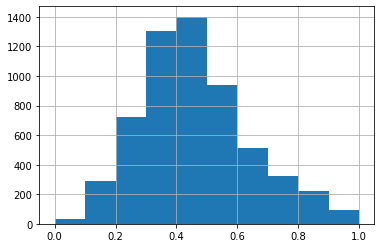

In [11]:
df_ = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")  # create a dateframe based on a file

print(df_.shape)  # display its size

df_ = df_[['txt', 'offensiveness_score']].rename(
    columns={
        'txt': 'text',
        'offensiveness_score':'y'
    }
)  # change columns

df_['y'] = (df_['y'] - df_.y.min()) / (df_.y.max() - df_.y.min())  # converting all toxicity values from 0 to 1
df_.y.hist()  # display all values on the histogram

# Create 3 versions of data

In [12]:
# Divide the resulting cleared dataframe by 7 and save each in a separate output csv file.
n_folds = 7  # number of folders

frac_1 = 0.7  # for all categories we take 70% of the original amount

for fld in range(n_folds):  # iterate over each of the 7 folders in turn
    print(f'Fold: {fld}')  # display the name of the currently formed folder
    tmp_df = df_.sample(frac=frac_1, random_state = 10*(fld+1))  # use handling of joining pandas objects along a specific axis with optional setup logic
    tmp_df.to_csv(f'/kaggle/working/df2_fld{fld}.csv', index=False)  # save the resulting folder dataframe to a csv file and mark it in a folder '/kaggle/working/'
    print(tmp_df.shape)  # display statistics for in this file
    print(tmp_df['y'].value_counts())  # display statistics in this file. As we can see, all files will contain the same number of lines.


Fold: 0
(4087, 2)
0.464668    125
0.475910    106
0.375268     94
0.442719     92
0.364561     89
           ... 
0.400964      1
0.889722      1
0.582976      1
0.404711      1
0.761242      1
Name: y, Length: 268, dtype: int64
Fold: 1
(4087, 2)
0.464668    107
0.475910    103
0.408994    102
0.386510     97
0.364561     88
           ... 
0.851713      1
0.859743      1
0.051927      1
0.666488      1
0.594754      1
Name: y, Length: 264, dtype: int64
Fold: 2
(4087, 2)
0.464668    118
0.475910    102
0.386510     94
0.442719     92
0.364561     89
           ... 
0.261777      1
0.238223      1
0.123126      1
0.694861      1
0.309422      1
Name: y, Length: 265, dtype: int64
Fold: 3
(4087, 2)
0.464668    116
0.475910    106
0.386510     93
0.408994     92
0.364561     90
           ... 
0.238223      1
0.561028      1
0.404711      1
0.806210      1
0.184154      1
Name: y, Length: 263, dtype: int64
Fold: 4
(4087, 2)
0.464668    122
0.475910    114
0.386510    100
0.442719     91
0.

In [13]:
del tmp_df, df_;  # remove the applied date frames
gc.collect()  # With no arguments, run a full collection

42

## Load Validation and Test data  
now we read the data file of the current competition and transfer it to the dataframe

In [14]:

# Validation data 

df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")  # create a variable dataframe containing data from the original competition data file
print(df_val.shape)  # display statistics for in this file
print(df_val.head())  # display the first 5 rows of the dataframe table

(30108, 3)
   worker  \
0     313   
1     188   
2      82   
3     347   
4     539   

                                                                                                                                                                                                                                  less_toxic  \
0                                                                                                                                                                                                    This article sucks \n\nwoo woo wooooooo   
1  "And yes, people should recognize that but they usually don't. One of the first objections you hear directed at someone who says he favors free markets is invariably ""There's no such thing as a free market."" Ridiculously trivial. "   
2                                                                                                                                         Western Media?\n\nYup, because every crime in the en

In [15]:
# Test data

df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")  # create a variable dataframe containing data from the original competition data file
print(df_sub.shape)  # display statistics for in this file
print(df_sub.head())


(7537, 2)
   comment_id  \
0      114890   
1      732895   
2     1139051   
3     1434512   
4     2084821   

                                                                                                                                                                                                                                                                                                          text  
0  "\n \n\nGjalexei, you asked about whether there is an ""anti-editorializing"" policy here.  There is, and it's called wikipedia:neutral point of view.  It discusses at some length  the case of what we should do when writing about a subject which most of us find repugnant.  Whilst you're not like...  
1                                                                                                                                                                                                                                       Looks like be have an abuser , can you please

# Create Sklearn Pipeline with 
## TFIDF - Take 'char_wb' as analyzer to capture subwords well
## Ridge - Ridge is a simple regression algorithm that will reduce overfitting 

### model Ridge - Linear least squares with l2 regularization.

Minimizes the objective function:

||y - Xw||^2_2 + alpha * ||w||^2_2

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization. This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

### Linear Regression - ordinary least squares .

Linear Regression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [16]:
# NOT USED 
# class LengthTransformer(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return sparse.csr_matrix([[(len(x)-360)/550] for x in X])
#     def get_feature_names(self):
#         return ["lngth"]

class LengthUpperTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return sparse.csr_matrix(
            [
                [
                    sum([1 for y in x if y.isupper()])/len(x)
                ] for x in X
            ]
        )
    def get_feature_names(self):
        return ["lngth_uppercase"]

### Does % of uppercase characters have effect on toxicity


0.06762926181756569 0.1429820536279063
0.10522553566497922 0.20361944552165576


<AxesSubplot:>

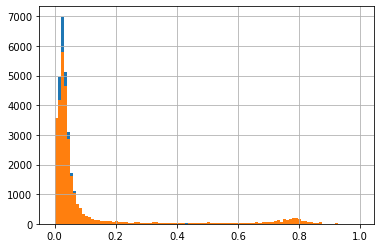

In [17]:

df_val['upper_1'] = np.array(LengthUpperTransformer().transform(df_val['less_toxic']).todense()).reshape(-1,1)
df_val['upper_2'] = np.array(LengthUpperTransformer().transform(df_val['more_toxic']).todense()).reshape(-1,1)

print(df_val['upper_1'].mean(), df_val['upper_1'].std())
print(df_val['upper_2'].mean(), df_val['upper_2'].std())

df_val['upper_1'].hist(bins=100)
df_val['upper_2'].hist(bins=100)

## Train pipeline

- Load folds data
- train pipeline
- Predict on validation data
- Predict on test data

pipeline module implements utilities to build a composite estimator, as a chain of transforms and estimators.

### Toxic data

In [18]:
val_preds_arr1 = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2 = np.zeros((df_val.shape[0], n_folds))
test_preds_arr = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 146616
[('vect3__uck', 0.53),
 ('vect3__fuc', 0.49),
 ('vect3__ ass', 0.4),
 ('vect3__fuck', 0.38),
 ('vect3__ f ', 0.34),
 ('vect3__ass', 0.32),
 ('vect3__fag', 0.32),
 ('vect3__shit', 0.31),
 ('vect3__ f*', 0.3),
 ('vect3__ fag', 0.29),
 ('vect3__gay', 0.28),
 ('vect3__nig', 0.28),
 ('vect3__nl3', 0.28),
 ('vect3__ fu', 0.27),
 ('vect3__dick', 0.27),
 ('vect3__hit', 0.27),
 ('vect3__nigg', 0.27),
 ('vect3__ck ', 0.26),
 ('vect3__fuk', 0.26),
 ('vect3__ g ', 0.25),
 ('vect3__ nl', 0.25),
 ('vect3__ die', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__dum', 0.24),
 ('vect3__gga', 0.24),
 ('vect3__kill ', 0.24),
 ('vect3__ ass.', 0.23),
 ('vect3__ u ', 0.23),
 ('vect3__cun', 0.23),
 ('vect3__igg', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 145297


# Toxic __clean__ data

In [19]:
val_preds_arr1c = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2c = np.zeros((df_val.shape[0], n_folds))
test_preds_arrc = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df_clean_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1c[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2c[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arrc[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(28394, 2)

Train:

Total number of features: 133784
[('vect3__uck', 0.5),
 ('vect3__ f ', 0.48),
 ('vect3__fuc', 0.45),
 ('vect3__ ass', 0.37),
 ('vect3__fuck', 0.35),
 ('vect3__shit', 0.32),
 ('vect3__ ck', 0.31),
 ('vect3__fag', 0.31),
 ('vect3__ fu', 0.29),
 ('vect3__ass', 0.29),
 ('vect3__ k ', 0.28),
 ('vect3__ re ', 0.28),
 ('vect3__hit', 0.28),
 ('vect3__ck ', 0.27),
 ('vect3__fuk', 0.27),
 ('vect3__nig', 0.27),
 ('vect3__nl3', 0.27),
 ('vect3__ fag', 0.26),
 ('vect3__gga', 0.26),
 ('vect3__dick', 0.25),
 ('vect3__gay', 0.25),
 ('vect3__suck', 0.25),
 ('vect3__ ass.', 0.24),
 ('vect3__ g ', 0.24),
 ('vect3__ gay', 0.24),
 ('vect3__ nl', 0.24),
 ('vect3__nigg', 0.24),
 ('vect3__ ass ', 0.23),
 ('vect3__ fuk', 0.23),
 ('vect3__ rape', 0.23)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(28394, 2)

Train:

Total number of features: 13

## Ruddit data pipeline

In [20]:
val_preds_arr1_ = np.zeros((df_val.shape[0], n_folds))
val_preds_arr2_ = np.zeros((df_val.shape[0], n_folds))
test_preds_arr_ = np.zeros((df_sub.shape[0], n_folds))

for fld in range(n_folds):
    print("\n\n")
    print(f' ****************************** FOLD: {fld} ******************************')
    df = pd.read_csv(f'/kaggle/working/df2_fld{fld}.csv')
    print(df.shape)

    features = FeatureUnion([
        #('vect1', LengthTransformer()),
        #('vect2', LengthUpperTransformer()),
        ("vect3", TfidfVectorizer(min_df= 3, max_df=0.5, analyzer = 'char_wb', ngram_range = (3,5))),
        #("vect4", TfidfVectorizer(min_df= 5, max_df=0.5, analyzer = 'word', token_pattern=r'(?u)\b\w{8,}\b')),

    ])
    pipeline = Pipeline(
        [
            ("features", features),
            #("clf", RandomForestRegressor(n_estimators = 5, min_sample_leaf=3)),
            ("clf", Ridge()),
            #("clf",LinearRegression())
        ]
    )
    print("\nTrain:")
    # Train the pipeline
    pipeline.fit(df['text'], df['y'])
    
    # What are the important features for toxicity

    print('\nTotal number of features:', len(pipeline['features'].get_feature_names()) )

    feature_wts = sorted(list(zip(pipeline['features'].get_feature_names(), 
                                  np.round(pipeline['clf'].coef_,2) )), 
                         key = lambda x:x[1], 
                         reverse=True)

    pprint(feature_wts[:30])
    
    print("\npredict validation data ")
    val_preds_arr1_[:,fld] = pipeline.predict(df_val['less_toxic'])
    val_preds_arr2_[:,fld] = pipeline.predict(df_val['more_toxic'])

    print("\npredict test data ")
    test_preds_arr_[:,fld] = pipeline.predict(df_sub['text'])




 ****************************** FOLD: 0 ******************************
(4087, 2)

Train:

Total number of features: 31907
[('vect3__fuc', 0.59),
 ('vect3__fuck', 0.59),
 ('vect3__uck', 0.55),
 ('vect3__ fuc', 0.52),
 ('vect3__ fuck', 0.52),
 ('vect3__ fu', 0.42),
 ('vect3__shit', 0.4),
 ('vect3__hit', 0.37),
 ('vect3__ shit', 0.36),
 ('vect3__fuck ', 0.34),
 ('vect3__ck ', 0.32),
 ('vect3__uck ', 0.31),
 ('vect3__shi', 0.29),
 ('vect3__ shi', 0.28),
 ('vect3__ ass ', 0.27),
 ('vect3__sex', 0.26),
 ('vect3__ ass', 0.25),
 ('vect3__ dick', 0.25),
 ('vect3__dick', 0.25),
 ('vect3__ dic', 0.24),
 ('vect3__ sex', 0.24),
 ('vect3__ sh', 0.23),
 ('vect3__shit ', 0.23),
 ('vect3__ass', 0.21),
 ('vect3__ di', 0.19),
 ('vect3__ du', 0.18),
 ('vect3__!!!', 0.18),
 ('vect3__dic', 0.18),
 ('vect3__ex ', 0.18),
 ('vect3__hit ', 0.18)]

predict validation data 

predict test data 



 ****************************** FOLD: 1 ******************************
(4087, 2)

Train:

Total number of features:

In [21]:
del df, pipeline, feature_wts
gc.collect()

597

# Validate the pipeline 

In [22]:
print(" Toxic data ")
p1 = val_preds_arr1.mean(axis=1)
p2 = val_preds_arr2.mean(axis=1)

print(f'Validation Accuracy is { np.round((p1 < p2).mean() * 100,2)}')

print(" Ruddit data ")
p3 = val_preds_arr1_.mean(axis=1)
p4 = val_preds_arr2_.mean(axis=1)

print(f'Validation Accuracy is { np.round((p3 < p4).mean() * 100,2)}')

print(" Toxic CLEAN data ")
p5 = val_preds_arr1c.mean(axis=1)
p6 = val_preds_arr2c.mean(axis=1)

print(f'Validation Accuracy is { np.round((p5 < p6).mean() * 100,2)}')


 Toxic data 
Validation Accuracy is 68.46
 Ruddit data 
Validation Accuracy is 62.57
 Toxic CLEAN data 
Validation Accuracy is 68.28


In [23]:
print("Find right weight")

wts_acc = []
for i in range(30,70,1):
    for j in range(0,20,1):
        w1 = i/100
        w2 = (100 - i - j)/100
        w3 = (1 - w1 - w2 )
        p1_wt = w1*p1 + w2*p3 + w3*p5
        p2_wt = w1*p2 + w2*p4 + w3*p6
        wts_acc.append( 
            (
                w1,w2,w3, 
                np.round((p1_wt < p2_wt).mean() * 100,2)
            )
        )
sorted(wts_acc, key=lambda x:x[3], reverse=True)[:5]

Find right weight


[(0.54, 0.29, 0.16999999999999998, 69.04),
 (0.55, 0.29, 0.15999999999999998, 69.04),
 (0.56, 0.29, 0.14999999999999997, 69.04),
 (0.64, 0.24, 0.12, 69.03),
 (0.68, 0.24, 0.07999999999999996, 69.03)]

In [24]:
w1,w2,w3,_ = sorted(wts_acc, key=lambda x:x[2], reverse=True)[0]
#print(best_wts)

p1_wt = w1*p1 + w2*p3 + w3*p5
p2_wt = w1*p2 + w2*p4 + w3*p6


## Analyze bad predictions 
### Incorrect predictions with similar scores
### Incorrect predictions with different scores

In [25]:
df_val['p1'] = p1_wt
df_val['p2'] = p2_wt
df_val['diff'] = np.abs(p2_wt - p1_wt)

df_val['correct'] = (p1_wt < p2_wt).astype('int')


In [26]:

### Incorrect predictions with similar scores

df_val[df_val.correct == 0].sort_values('diff', ascending=True).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
21672,674,"""Why is there even an """"Edit"""" option anyway?\nMaybe if they took it off there wouldn't be as much vandalism.\n\n""","I've blocked you (again, sigh). .",0.027027,0.028571,0.199001,0.198984,0.000017,0
23238,666,"""It's not all of a sudden, check the article's discussion page, I have proven that he's an Arab: so, not all sources agree. Also, please do tell me what other """"numerous sources"""" you have to provide? Obviously it's a weasel word, you only have one source, same as me. This makes it at the very ...","""bomb in the Diplomat hotel 20 minutes ago...after the feast...tell the government that we will destroy everyplace."""" \n """,0.020000,0.008264,0.251985,0.251953,0.000033,0
467,729,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.030612,0.000000,0.261888,0.261805,0.000083,0
466,171,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.030612,0.000000,0.261888,0.261805,0.000083,0
465,9,"RE: Pygmy Guru \n\nI'm not asking for your support. I'm expressing my general dismay in finding my article deleted. All the time and thought put into that article was wasted. Wikipedia is the collaboration of minds and people, to create a digital encyclopedia where simple folk like myself can v...",nonsense? \n\nwho are you to tell me that my truthful info about rfk jr is nonsense?,0.030612,0.000000,0.261888,0.261805,0.000083,0
14876,513,"Jesus, how much other stuff are you white washing?","""\n\n""""The WWE Raw guest host initiative was introduced on June 15, 2009 by Donald Trump during his time as owner of the Raw franchise."""" This is Wikipedia all over. Listing stories as facts...Jesus Christ. Grow a brain, the first step might be to stop watching a product churned solely for child...",0.019608,0.096491,0.280798,0.280698,0.000099,0
14877,268,"Jesus, how much other stuff are you white washing?","""\n\n""""The WWE Raw guest host initiative was introduced on June 15, 2009 by Donald Trump during his time as owner of the Raw franchise."""" This is Wikipedia all over. Listing stories as facts...Jesus Christ. Grow a brain, the first step might be to stop watching a product churned solely for child...",0.019608,0.096491,0.280798,0.280698,0.000099,0
2934,686,"""\n\nOh hell... i will not remove my personel opionion... can't you make it simple for all and block me for 2 weeks due to my personal attack?... [here is something funny, consider it as a break for exhausting thoughts """"Lost - what happens next"""" > ] ""","Drop Dead! \n\nI'm not gonna bother with you, wait till my dad comes.",0.007905,0.044118,0.242709,0.242600,0.000109,0
4862,173,"""No, what you've done is prove you're clueless.\n\n1) DID YOU READ THE TAG THAT THE ADMINISTRATOR PUT AT THE TOP OF THE PAGE? OBJECTIONS ARE TO GO TO THE DISCUSSION PAGE WHILE THE PAGE IS UNDER CONSTRUCTION. STOP BEING A PEST. YOU'RE NOT HELPINGYOUR GRINDING YOUR PERSONAL AXE like an immature li...","Ciao\n\nWhats up with that ? I thought Sonny Bonno was dead. You could very well be a man I knew from Youngstown., or perhaps Michigan. But that Ciao bullshit reminds me of Charlie.....Smith was actually directed by the California office to sell off those shops. Although many times his conversat...",0.228996,0.037866,0.313909,0.313791,0.000118,0
4861,416,"""No, what 

#### Some of these just look incorrectly tagged 


In [27]:
### Incorrect predictions with dis-similar scores


df_val[df_val.correct == 0].sort_values('diff', ascending=False).head(20)

,worker,less_toxic,more_toxic,upper_1,upper_2,p1,p2,diff,correct
25062,246,CaliforniaAliBaba is a Bitch\nGo fuck yourself you bitch ass motherfucker. Don't you ever in your fucking life threatening me you fucking piece of shit you. You don't know me I will fucking kill your ass you punk pussy bitch. tell your mama to my black dick.,I've heard a snippet on their myspace page but I'm afraid I haven't given them much though musically as of yet. Perhaps I will be purchasing one of their albums since I seem to spend about a third of my time on wiki reverting their vandalism.,0.031128,0.024390,1.177302,0.166488,1.010814,0
25754,190,what the hell man? why did you delete my page (savannah hoard) screw you dude\n\ni mean really? if you're not gonna let me have a page then you can go fuck your fat self you 40 year old bitch\n\nyour a total bitch who goes around deleting people's pages you fucking disgust me im gonna kick your ...,""" December 2009 (UTC)\n\n Now there's typical AGW alarmist Watermelon argumentum ad hominem content-vacant suppressive authoritarian WikiNazi rottenness if ever it got posted online. Don't address Monckton's (or Nsaa's) position, but strive (with utter ineffectiveness, I might add) to fault the ...",0.000000,0.039146,0.993966,0.239850,0.754116,0
17192,347,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.040056,0.308217,0.731840,0
17193,238,fuck this this is bull shit and it does not even say where shit comes from your fucking ass,Just To Let You Know. You have no life.\nI hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I hate you.I ...,0.000000,0.091365,1.040056,0.308217,0.731840,0
21059,333,fuck you \n\nyou're an idiot,"What makes you an editor? Why do you use the name of a great dead man? What is your true name, profession, country? \nShamir",0.000000,0.032520,0.970549,0.245772,0.724778,0
9520,102,by the way I AM A FUCKIN FAG FUCK U,"You are a troublemaker, a liar, and a malicious scumbag. If you are looking for trouble, then keep removing links from the article.",0.500000,0.015038,1.000642,0.287374,0.713268,0
20435,504,Fuck you niggerkite. y you deleting so much shit. fuckn loser. dont delete anymore shit. its none of your fucking business,"Bush is the man. \n\nHe had the balls to dispose of Saddam and declare war on Islamic fundamentalism. Regardless of how he went about doing it, or his interest in oil, he did it. He can have the oil, if that's what he wants in return for ridding the world of religious tyranny (hopefully startin...",0.008197,0.027027,0.975801,0.263068,0.712733,0
19411,46,"Ok, what is it \n\nWhy are you such a queer.. you have no power, so why the FUCK are you acting like you do. Grow up you fucking stupid shit head cock eating bastard.. seriously! Get a life, you're just a 17 yo piece of shit.",wow the guy who deleated the stuff on the Habbo NSM is leet. 88!,0.035714,0.062500,0.957250,0.249128,0.708122,0
14595,415,"Hello fuckhead,\nContributions my faggot asshole. You think that because im gay that i dont know shit. you are wrong. you just sit there with nothing to do with your pathetic fucking life that you decide to go and be a complete prick on wikipedia and just delete whatever the fuck u want. Thanks ...",User Syrthiss is a mot*herfuc*ker assh*ole ha ha ha,0.013115,0.039216,1.076641,0.382659,0.693982,0
4866,609,Hey Man\nYou are a retarded Mexican cocksucking piece of fucking shit. Please go fucking kill yourself. Wikipedia admins are lowe

# Predict on test data 

In [28]:
# Predict using pipeline

df_sub['score'] = w1*test_preds_arr.mean(axis=1) + w2*test_preds_arr_.mean(axis=1) + w3*test_preds_arrc.mean(axis=1)

In [29]:
#test_preds_arr

## Correct the rank ordering

In [30]:
# Cases with duplicates scores

df_sub['score'].count() - df_sub['score'].nunique()

13

In [31]:
same_score = df_sub['score'].value_counts().reset_index()[:10]
same_score

,index,score
0,0.553254,2
1,0.320794,2
2,0.323360,2
3,0.288264,2
4,0.342407,2
5,0.707011,2
6,0.338967,2
7,0.167897,2
8,0.367004,2
9,0.295053,2


In [32]:
df_sub[df_sub['score'].isin(same_score['index'].tolist())]

,comment_id,text,score
1832,95080362,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167897
2842,160935265,"""\n\nPlease do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you. melmac """,0.167897
4757,270227263,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.707011
4759,270227815,YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! YOU ARE A MOTHJER FUCKER COCKSUCKER! ...,0.707011
5752,339478276,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.338967
5753,339478966,"I'm gonna beat you to a bloody pulp then shoot you, execution-style. \n\nI'm gonna beat you to a bloody pulp then shoot you, execution-style.",0.338967
5832,345043812,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.367004
5833,345043888,JIMBO SAID I COULD EDIT HIS PAGE. YOU ARE A MORON.,0.367004
5852,346641598,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS,0.288264
5853,346641762,WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS WE ARE GOING TO MAKE SURE YOU ARE EXPOSED!! DROP YOUR RELATIONS WITH ANTI AMERICAN HATE GROUPS 'WE ARE GO...,0.288264


In [33]:
# Same comments have same score - which is ok 

In [34]:
# # Rank the predictions 

# df_sub['score']  = scipy.stats.rankdata(df_sub['score'], method='ordinal')

# print(df_sub['score'].rank().nunique())

# Bert Ensemble

In [35]:
%%time
# connect libraries only for this task
import os  # operating system library
import gc  # Garbage Collector - module provides the ability to disable the collector, tune the collection frequency, and set debugging options
import cv2  # open source computer vision and machine learning library
import copy  # The assignment operation does not copy the object, it only creates a reference to the object. 
# For mutable collections, or for collections containing mutable items, a copy is often needed so that it can be modified without changing the original. 
# This module provides general (shallow and deep) copy operations. 

import time  # time library
import random  # library for working with random values

# For data manipulation
import pandas as pd  # data analysis library
import numpy as np  # library linear algebra, Fourier transform and random numbers

# Pytorch Imports
import torch  #  a Tensor library like NumPy, with strong GPU support
import torch.nn as nn  # a neural networks library deeply integrated with autograd designed for maximum flexibility
from torch.utils.data import Dataset, DataLoader  # DataLoader and other utility functions for convenience


# For Transformer Models
from transformers import AutoTokenizer, AutoModel  # In many cases, the architecture you want to use can be guessed from the name or the path of the 
# pretrained model you are supplying to the from_pretrained() method. AutoClasses are here to do this job for you so that you automatically retrieve the 
# relevant model given the name/path to the pretrained weights/config/vocabulary.
#Instantiating one of AutoConfig, AutoModel, and AutoTokenizer will directly create a class of the relevant architecture.

# Utils
from tqdm import tqdm  # tqdm derives from the Arabic word taqaddum  which can mean "progress," and is an abbreviation for "I love you so much" in Spanish 
# (te quiero demasiado).  this library show a smart progress meter - just wrap any iterable with tqdm(iterable)

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

CONFIG = dict(
    seed = 42,
    model_name = '../input/roberta-base',
    test_batch_size = 64,
    max_length = 128,
    num_classes = 1,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
)

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])



MODEL_PATHS = [
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-0.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-1.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-2.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-3.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-4.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-5.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-6.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-7.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-8.bin',
    '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-9.bin'
]



def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len,
                        padding='max_length'
                    )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long)
        }    

    
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs
    
@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.view(-1).cpu().detach().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS


def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = JigsawModel(CONFIG['model_name'])
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))  # for cpu
        # model.load_state_dict(torch.load(path))  # for gpu
       
        
        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds


set_seed(CONFIG['seed'])
df = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
df.head()

test_dataset = JigsawDataset(df, CONFIG['tokenizer'], max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['test_batch_size'],
                         num_workers=2, shuffle=False, pin_memory=True)

preds1 = inference(MODEL_PATHS, test_loader, CONFIG['device'])

FileNotFoundError: [Errno 2] No such file or directory: '../input/fork-of-pytorch-w-b-my-jigsaw-starter/Loss-Fold-0.bin'

In [36]:
preds = (preds1-preds1.min())/(preds1.max()-preds1.min())

NameError: name 'preds1' is not defined

In [ ]:
df_sub['score'] = df_sub['score']*0.85+preds*0.15  # preparation of the output, we select the coefficient empirically 0.82->0.85->0.90, 0.17->0.15->0.10

In [ ]:
df_sub[['comment_id', 'score']].to_csv("submission.csv", index=False)  # we form an output file for evaluation in the competition